In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import RobustScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib

In [2]:
# Load dataset
df = pd.read_csv('heart_disease_uci.csv')

# Data Exploration and Preprocessing 

In [3]:
# Get an overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [4]:
# No duplicates in dataset
df[df.duplicated()]

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num


## Column: sex

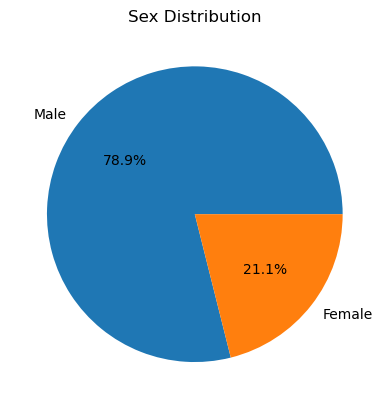

In [5]:
# Pie chart to display patients' gender distribution
# sex is very imbalanced as vast majority of patients are male
sex_counts = df['sex'].value_counts()
plt.pie(sex_counts, labels = ['Male', 'Female'], autopct='%1.1f%%')
plt.title('Sex Distribution')
plt.show()

## Column: dataset

In [6]:
# dataset is actually the locations of origin for the data. 
df['dataset'].unique()

array(['Cleveland', 'Hungary', 'Switzerland', 'VA Long Beach'],
      dtype=object)

In [7]:
# Drop id and dataset as they are useless for prediction
# Drop sex as well as it is not so useful for prediction 
df = df.drop(columns=['id', 'dataset', 'sex'])

In [8]:
# Remaining columns 
df.columns

Index(['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

## Column: num 

In [9]:
# Target column, num, has 5 values. 
# 0 - No heart disease 
# 1-4 - Varying degrees of disease from least to most severe
df['num'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

In [10]:
# As the model's purpose will just be to find out if the person has heart disease, bin values 1-4 into simply 1
# Model will predict 0 or 1 only. 
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# Verify change
df['num'].unique()

array([0, 1], dtype=int64)

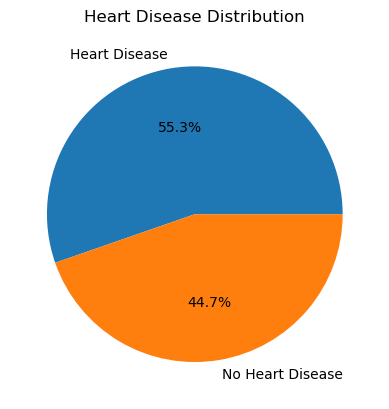

In [12]:
# Get the counts of the number of patients with and without heart disease 
heart_disease_counts = df['num'].value_counts()
# Pie chart to display the distribution of patients with and without heart disease in the dataset
plt.pie(heart_disease_counts, labels = ['Heart Disease', 'No Heart Disease'], autopct='%1.1f%%')
plt.title('Heart Disease Distribution')
plt.show()

In [13]:
# Rename columns for greater clarity
# tresbps is not renamed yet as it is unclear which blood pressure exactly it refers to 
df= df.rename(columns = {'cp':'chest_pain_type', 'chol':'cholesterol', 'fbs': 'high_fasting_blood_sugar', 'thalch': 'max_heart_rate', 'exang':'exercise_induced_angina', 'oldpeak':'st_depression', 'ca':'colored_vessels', 'thal':'thalassemia', 'num':'has_heart_disease'})

In [14]:
# Look at the renamed columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       920 non-null    int64  
 1   chest_pain_type           920 non-null    object 
 2   trestbps                  861 non-null    float64
 3   cholesterol               890 non-null    float64
 4   high_fasting_blood_sugar  830 non-null    object 
 5   restecg                   918 non-null    object 
 6   max_heart_rate            865 non-null    float64
 7   exercise_induced_angina   865 non-null    object 
 8   st_depression             858 non-null    float64
 9   slope                     611 non-null    object 
 10  colored_vessels           309 non-null    float64
 11  thalassemia               434 non-null    object 
 12  has_heart_disease         920 non-null    int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 93.6+ KB


In [15]:
# Define a function to calculate Cramer's V to check correlation between categorical columns based on rows without missing values
def calculate_cramers_v(target_column):
    '''
    The function will compare the target_column with every other categorical column
    
    Arguments: 
    target_column: The current column being examined 
    
    Returns:
    Cramer's V calculations comparing target_column and each other column
    '''
    # Define a list with the names of all categorical columns in the dataset
    categorical_columns = ['chest_pain_type', 'high_fasting_blood_sugar', 'restecg', 'exercise_induced_angina', 'slope', 'thalassemia']

    for column in categorical_columns:
        # Compare the column names to see if target_column is being compared to itself
        # If it is, skip this column 
        if column == target_column.name:
            continue 
        else:
            # If not, get the categorical column using the name and proceed with calculation
            column = df[column]
            
            # Create a contingency table of target_column and column
            contingency_table = np.array(pd.crosstab(target_column, column))
        
            # Get chi square value
            chi_square = stats.chi2_contingency(contingency_table, correction=False)[0]
        
            # Calculate Cramer's V using contingency table details and chi square value 
            sample_size = np.sum(contingency_table)
            min_dimensions = min(contingency_table.shape)-1
            cramers_v = np.sqrt((chi_square / sample_size) / min_dimensions)
            
            # Display Cramer's V
            print(f'{target_column.name} and {column.name} correlation:', cramers_v.round(2))

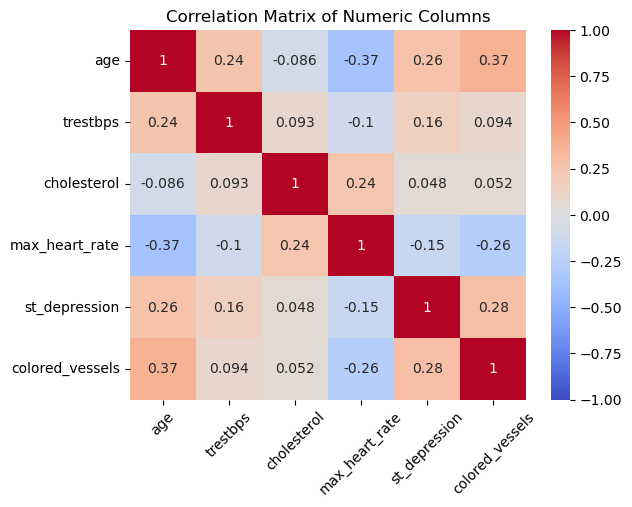

In [16]:
# Define DataFrame of solely numeric columns
numeric_columns = df[['age', 'trestbps', 'cholesterol', 'max_heart_rate', 'st_depression', 'colored_vessels']]

# Compute correlation matrix for numeric columns
numeric_correlation_matrix = numeric_columns.corr()

# Plot a heatmap of the correlation matrix
sns.heatmap(numeric_correlation_matrix, vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True)
plt.title('Correlation Matrix of Numeric Columns')
plt.xticks(rotation=45)
plt.show()

# There is little correlation between numeric columns in general, so multi-collinearity between them is no issue
# colored_vessels and age, max_heart_rate and age seem to have moderate correlation

## Column: age

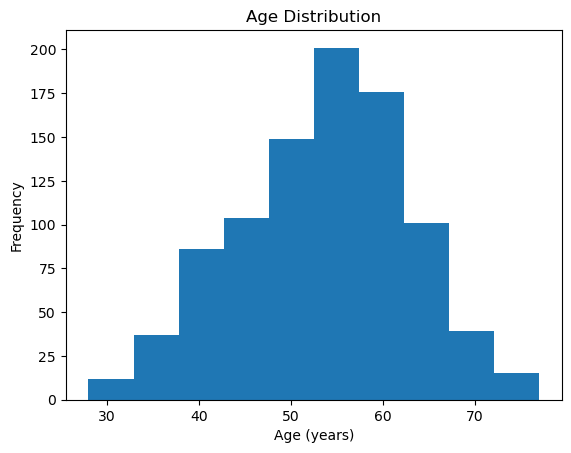

In [17]:
# Create histogram to view age distribution 
df['age'].plot(kind = 'hist', title = 'Age Distribution', xlabel = 'Age (years)', ylabel = 'Frequency')
plt.show()

# It is moderately left-skewed, likely due to the fact that older patients are checked for heart disease more 

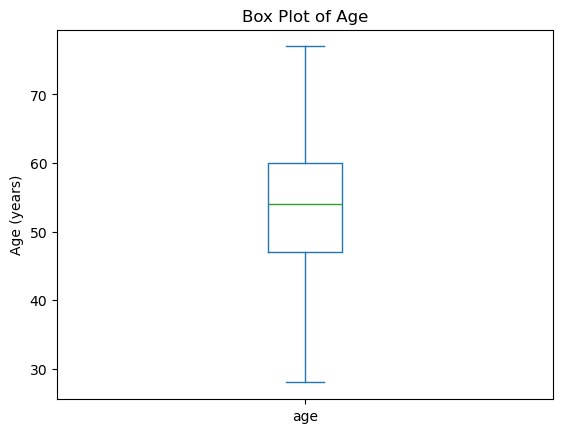

In [18]:
# Box plot to find distribution and outliers of age
df['age'].plot(kind = 'box', title = 'Box Plot of Age', ylabel = 'Age (years)')

plt.show()
# The range is wide for age and there are no outliers
# The interquartile range is mainly representing middle-aged individuals

## column: chest_pain_type

In [19]:
# Look at unique values in chest_pain_type 
df['chest_pain_type'].unique()

array(['typical angina', 'asymptomatic', 'non-anginal', 'atypical angina'],
      dtype=object)

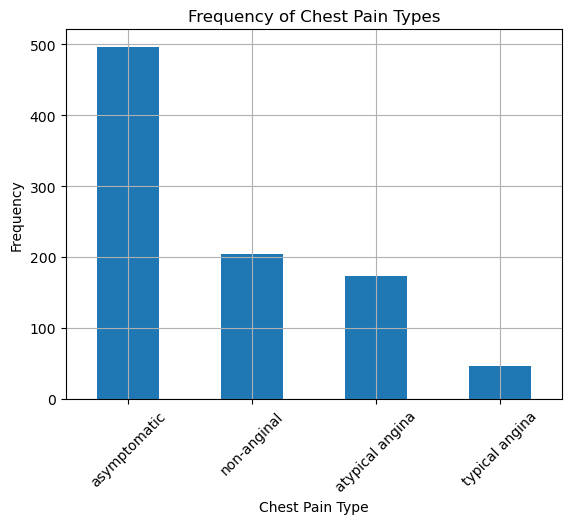

In [20]:
# Get the counts of each chest pain type
chest_pain_type_counts = df['chest_pain_type'].value_counts()
# Use a box plot to see the distribution of chest_pain_type
chest_pain_type_counts.plot(kind='bar', title = 'Frequency of Chest Pain Types', xlabel = 'Chest Pain Type', ylabel = 'Frequency', grid = True)
plt.xticks(rotation=45)

plt.show()

# A bulk of the patients are asymptomatic, meaning they don't display chest pains
# The chest pains distribution are not so balanced

In [21]:
# Check correlation between chest_pain_type and other categorical columns 
calculate_cramers_v(df['chest_pain_type'])

# No high correlations so no multicollinearity issues
# There is moderate correlation between chest_pain_type and exercise_induced_angina, likely because both columns involve angina 

chest_pain_type and high_fasting_blood_sugar correlation: 0.09
chest_pain_type and restecg correlation: 0.1
chest_pain_type and exercise_induced_angina correlation: 0.45
chest_pain_type and slope correlation: 0.2
chest_pain_type and thalassemia correlation: 0.27


## column: exercise_induced_angina

In [22]:
# exercise_induced_angina is whether or not the patient has anginal pains from exercise
# I will use this to cross-examine chest_pain_type as it is possible that patients only get chest pains from exercise, which will still indicate the presence of heart disease
df['exercise_induced_angina'].unique()

array([False, True, nan], dtype=object)

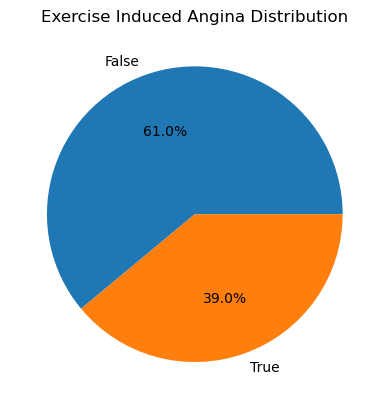

In [23]:
df['exercise_induced_angina'].value_counts()
# Check the proportion of exercise_induced_angina values 
new_heart_disease_counts = df['exercise_induced_angina'].value_counts()
# Pie chart to display the distribution 
plt.pie(new_heart_disease_counts, labels = ['False', 'True'], autopct='%1.1f%%')
plt.title('Exercise Induced Angina Distribution')
plt.show()

# The proportion is imablanced as a majority of patients do not display exercise induced angina, but the imabalance is not too serious

In [24]:
# Check correlation between exercise_induced_angina and other categorical columns 
calculate_cramers_v(df['exercise_induced_angina'])

# No high correlations so no multicollinearity issues
# There is moderate correlation between exercise_induced_angina and chest_pain_type, slope, thalassemia
# The relation between exercise_induced_angina and slope may be because the slope of the ST segment may imply the presence of Myocardial Ischemia, of which angina is a symptom

exercise_induced_angina and chest_pain_type correlation: 0.45
exercise_induced_angina and high_fasting_blood_sugar correlation: 0.03
exercise_induced_angina and restecg correlation: 0.09
exercise_induced_angina and slope correlation: 0.35
exercise_induced_angina and thalassemia correlation: 0.34


In [25]:
# Almost 6% of rows have missing exercise_induced_angina. 
exercise_induced_angina_missing = df['exercise_induced_angina'].isnull().sum() / len(df) * 100
print(exercise_induced_angina_missing.round(2))

5.98


In [26]:
# Group missing values by chest_pain_type and count occurrences
grouped_missing = df[df['exercise_induced_angina'].isnull()].groupby('chest_pain_type').size()
print(grouped_missing)
# Most missing values in exercise_induced_angina are tied to asymptomatic and non-anginal chest_pain_type
# This could be because the patient is not considered to be at risk as they display no anginal pains and does not undergo the exercise stress test 

chest_pain_type
asymptomatic       26
atypical angina     7
non-anginal        18
typical angina      4
dtype: int64


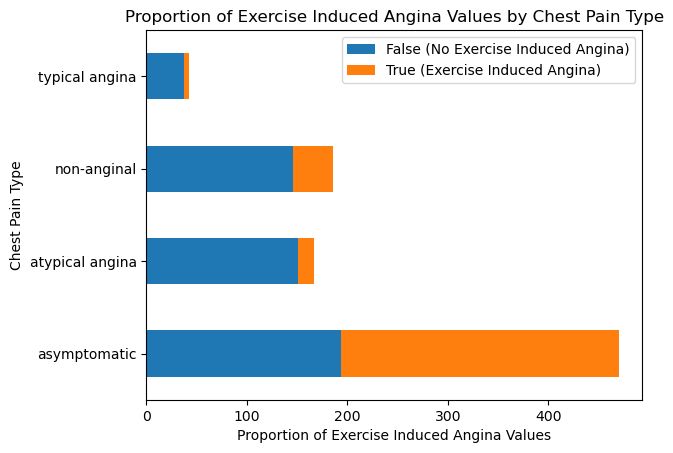

In [27]:
# exercise_induced_angina is whether or not the patient has anginal pains from exercise
# I will use this to cross-examine chest_pain_type as it is possible that patients only get chest pains from exercise, which will still indicate the presence of heart disease

# Plot stacked bar chart
df.groupby('chest_pain_type')['exercise_induced_angina'].value_counts().unstack().plot(kind='barh', stacked=True, title = 'Proportion of Exercise Induced Angina Values by Chest Pain Type', xlabel = 'Proportion of Exercise Induced Angina Values', ylabel = 'Chest Pain Type')

# Add labels and title
plt.legend(['False (No Exercise Induced Angina)', 'True (Exercise Induced Angina)'])

plt.show()

# For non-null values, over half of asymptomatic patients actually have exercise-induced angina
# This means that chest_pain_type cannot be relied on alone and exercise_induced_angina is needed for clarification 

In [28]:
# Considering there is moderate correlation between chest_pain_type and exercise_induced_angina, and their relationship, KNN imputation seems to be suitable for missing exercise_induced_angina values 

## Column: trestbps (later renamed top_rest_bps)

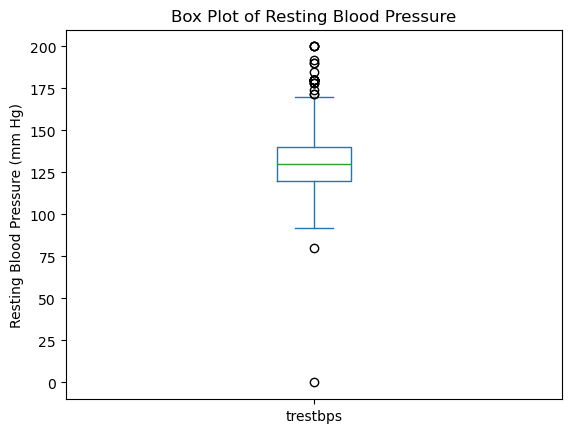

In [29]:
# Box plot to find distribution and outliers of trestbps
df['trestbps'].plot(kind = 'box', title = 'Box Plot of Resting Blood Pressure', ylabel = 'Resting Blood Pressure (mm Hg)')

plt.show()
# It can be assumed from the range of trestbps that it represents systolic blood pressure as its range similar 
# The presence of t in the column may imply it is is top number pressure as well. ie, systolic blood pressure

In [30]:
# Rename trestbps for clarity 
df= df.rename(columns = {'trestbps':'top_rest_bps'})

In [31]:
# Check all column names 
df.columns

Index(['age', 'chest_pain_type', 'top_rest_bps', 'cholesterol',
       'high_fasting_blood_sugar', 'restecg', 'max_heart_rate',
       'exercise_induced_angina', 'st_depression', 'slope', 'colored_vessels',
       'thalassemia', 'has_heart_disease'],
      dtype='object')

In [32]:
# 0 mm Hg is impossible, so the row is invalid and will be removed
# The rows where trestbps are higher than the maximum can be kept as they are possible
df = df[df['top_rest_bps'] != 0]

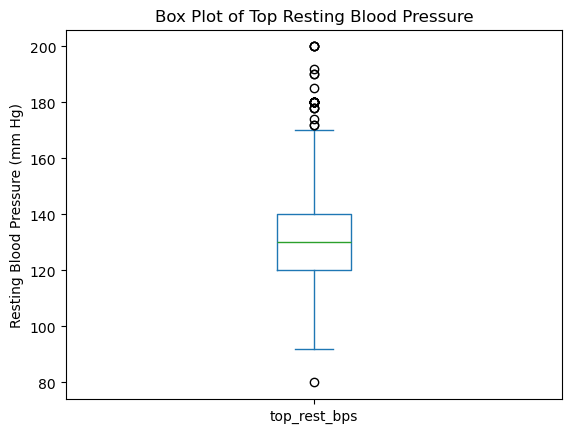

In [33]:
df['top_rest_bps'].plot(kind = 'box', title = 'Box Plot of Top Resting Blood Pressure', ylabel = 'Resting Blood Pressure (mm Hg)')

plt.show()

# Range has become wider without the value 0 outlier

In [34]:
# About 6% of values for top_rest_bps are missing 
bps_missing = df['top_rest_bps'].isnull().sum() / len(df) * 100
print(bps_missing.round(2))

6.42


In [35]:
# Retain top_rest_bps as it may be an indicator of heart disease 
# Impute with median so that it is not affected by the multiple outliers 
top_rest_bps_median = df['top_rest_bps'].median()
df['top_rest_bps'] = df['top_rest_bps'].fillna(top_rest_bps_median)  

In [36]:
df['top_rest_bps'].isnull().sum() 

0

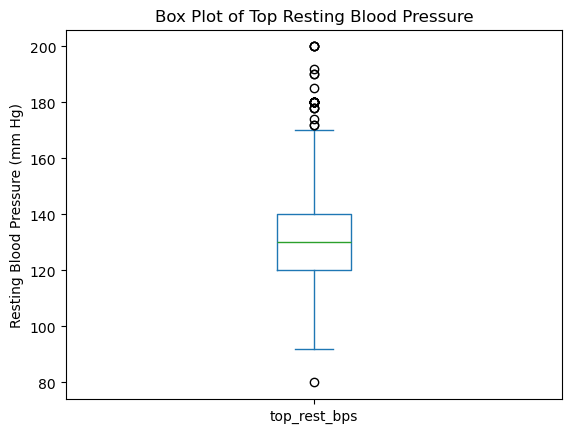

In [37]:
# Box plot to check new distribution of top_rest_bps after imputation
df['top_rest_bps'].plot(kind = 'box', title = 'Box Plot of Top Resting Blood Pressure', ylabel = 'Resting Blood Pressure (mm Hg)')

plt.show()
# The bottom outlier is no longer an ourlier. Range seems to be wider 

## Column: cholesterol

In [38]:
# About 3% of values for top_rest_bps are missing 
cholesterol_missing = df['cholesterol'].isnull().sum() / len(df) * 100
print(cholesterol_missing.round(2))

3.26


In [39]:
# As the percentage is small, the missing values in cholesterol could be removed
df = df[df['cholesterol'].notnull()]

In [40]:
# Verify that rows with missing have been removed
df['cholesterol'].isnull().sum()

0

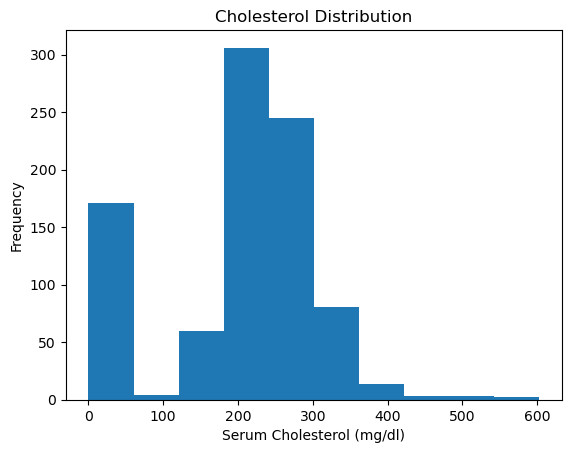

In [41]:
# Create histogram to view cholesterol distribution 
df['cholesterol'].plot(kind = 'hist', title = 'Cholesterol Distribution', xlabel = 'Serum Cholesterol (mg/dl)', ylabel = 'Frequency')
plt.show()

In [42]:
# cholesterol of 0 is impossible, so remove the rows with invalid value
df = df[df['cholesterol'] != 0]

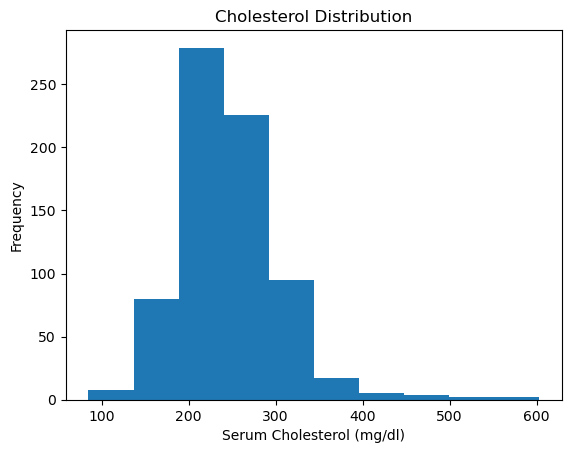

In [43]:
# Create histogram to view proper chol distribution 
df['cholesterol'].plot(kind = 'hist', title = 'Cholesterol Distribution', xlabel = 'Serum Cholesterol (mg/dl)', ylabel = 'Frequency')
plt.show()

# Right skewed mainly due to outliers 

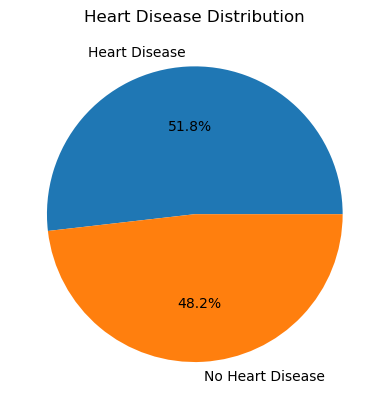

In [44]:
# Check the proportion of target values if rows with cholesterol missing values and rows where cholesterol = 0 mg/dlare removed
new_heart_disease_counts = df['has_heart_disease'].value_counts()
# Pie chart to display the distribution of patients with and without heart disease in the dataset if rows with cholesterol missing values are removed
plt.pie(new_heart_disease_counts, labels = ['Heart Disease', 'No Heart Disease'], autopct='%1.1f%%')
plt.title('Heart Disease Distribution')
plt.show()

# The proportion seems to be more balanced now 

In [45]:
# Get count of remaining rows 
df.shape[0]

718

## Column: high_fasting_blood_sugar

In [46]:
# Check correlation between high_fasting_blood_sugar and other categorical columns 
calculate_cramers_v(df['high_fasting_blood_sugar'])

# The correlation between high_fasting_blood_sugar and other categorical columns are low, so no multicollinearity issues 

high_fasting_blood_sugar and chest_pain_type correlation: 0.1
high_fasting_blood_sugar and restecg correlation: 0.16
high_fasting_blood_sugar and exercise_induced_angina correlation: 0.06
high_fasting_blood_sugar and slope correlation: 0.13
high_fasting_blood_sugar and thalassemia correlation: 0.16


In [47]:
# When compared with the remaining valid number of rows, about 1% of high_fasting_blood_sugar is missing 
high_fasting_blood_sugar_missing = (df['high_fasting_blood_sugar'].isnull().sum() / len(df)) * 100
print(high_fasting_blood_sugar_missing.round(2))

1.39


In [48]:
# The missing values can be removed as the proportion is small 
df = df[df['high_fasting_blood_sugar'].notnull()]

In [49]:
# Verify that rows with missing have been removed
df['high_fasting_blood_sugar'].isnull().sum()

0

In [50]:
# Remaining count of rows 
df.shape[0]

708

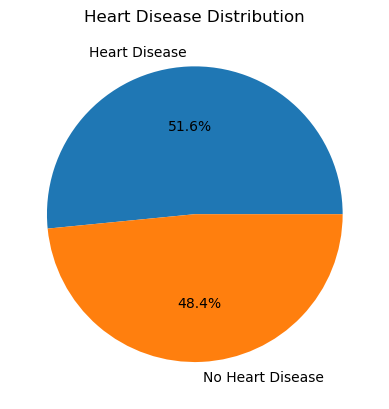

In [51]:
# Check the proportion of target values after removing the rows with missing values 
new_heart_disease_counts = df['has_heart_disease'].value_counts()
# Pie chart to display the distribution of patients with and without heart disease
plt.pie(new_heart_disease_counts, labels = ['Heart Disease', 'No Heart Disease'], autopct='%1.1f%%')
plt.title('Heart Disease Distribution')
plt.show()

# The proportion seems to be more balanced now 

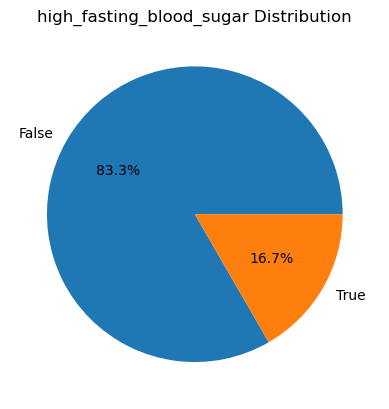

In [52]:
# Check the proportion of high_fasting_blood_sugar values 
high_fasting_blood_sugar_counts = df['high_fasting_blood_sugar'].value_counts()
# Pie chart to display the distribution of patients with and without blood sugar levels above 120 mg/dl
plt.pie(high_fasting_blood_sugar_counts, labels = ['False', 'True'], autopct='%1.1f%%')
plt.title('high_fasting_blood_sugar Distribution')
plt.show()

# Proportion of high_fasting_blood_sugar is imbalanced 

## Column: restecg

In [53]:
# Check correlation between restecg and other categorical columns 
calculate_cramers_v(df['restecg'])

# No high correlations so no multicollinearity issues

restecg and chest_pain_type correlation: 0.12
restecg and high_fasting_blood_sugar correlation: 0.16
restecg and exercise_induced_angina correlation: 0.13
restecg and slope correlation: 0.12
restecg and thalassemia correlation: 0.21


In [54]:
# There's only 1 row among the remaining valid rows with missing values in restecg
df['restecg'].isnull().sum()

1

In [55]:
# The row with missing values can be removed 
df = df[df['restecg'].notnull()]

In [56]:
# Verify that missing value has been removed 
df['restecg'].isnull().sum()

0

In [57]:
# Check remaining number of columns
df.shape[0]

707

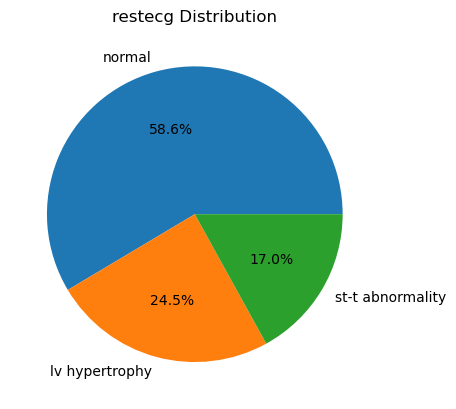

In [58]:
# Check the proportion of restecg values 
restecg_counts = df['restecg'].value_counts()
plt.pie(restecg_counts, labels = ['normal', 'lv hypertrophy', 'st-t abnormality'], autopct='%1.1f%%')
plt.title('restecg Distribution')
plt.show()

# Dominant value is 'normal'. The distribution is not so imbalanced in terms of normal vs non-normal restecg

## Column: max_heart_rate

In [59]:
# There's close to 6% missing values for max_heart_rate  
max_heart_rate_missing = df['max_heart_rate'].isnull().sum() / len(df) * 100
print(max_heart_rate_missing.round(2))

5.94


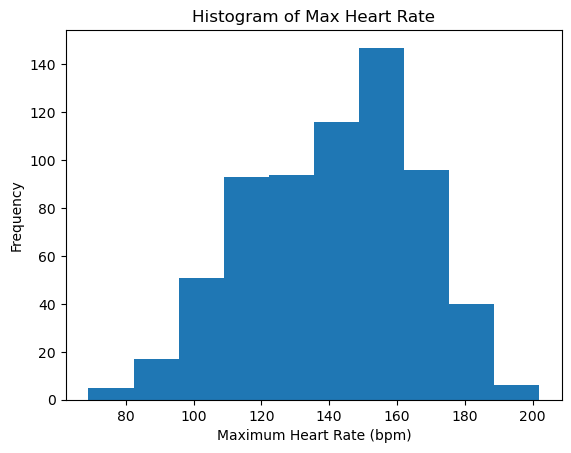

In [60]:
# Find the distribution of max_heart_rate
df['max_heart_rate'].plot(kind = 'hist', title = 'Histogram of Max Heart Rate', ylabel = 'Frequency', xlabel = 'Maximum Heart Rate (bpm)')

plt.show()

# The data is right skewed

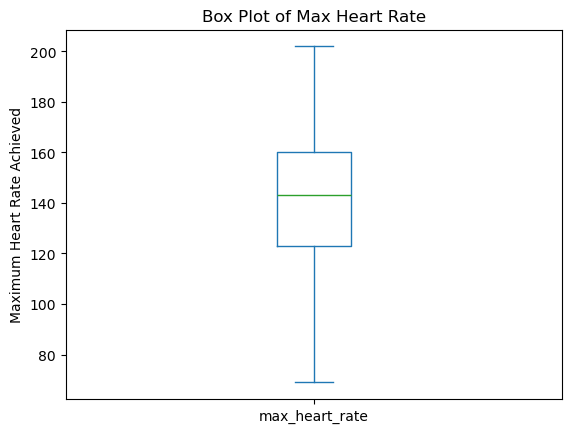

In [61]:
# Box plot to find distribution and outliers of max_heart_rate
df['max_heart_rate'].plot(kind = 'box', title = 'Box Plot of Max Heart Rate', ylabel = 'Maximum Heart Rate Achieved')

plt.show()
# There are no outliers in the remaining rows. This makes max_heart_rate suitable for KNN imputation
# KNN imputation is decided for max_heart_rate values as the maximum heart rate can be affected by pre-existing heart conditions (thalessamia, etc)

## Column: st_depression

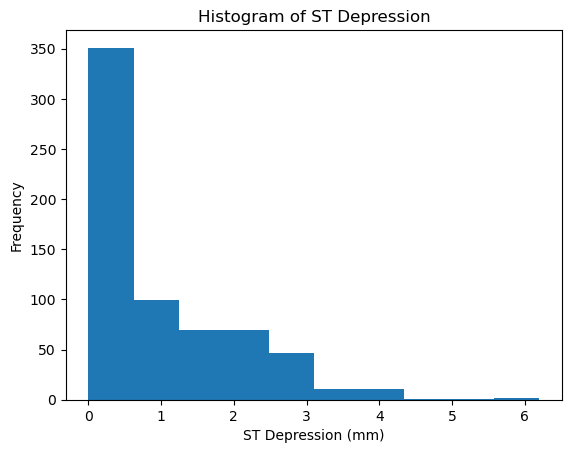

In [62]:
# Find the distribution of st_depression
df['st_depression'].plot(kind = 'hist', title = 'Histogram of ST Depression', ylabel = 'Frequency', xlabel = 'ST Depression (mm)')

plt.show()

# The data is left skewed
# 0 is the most frequent value likely because the results of the ecg for st depression may be normal, which is no depression

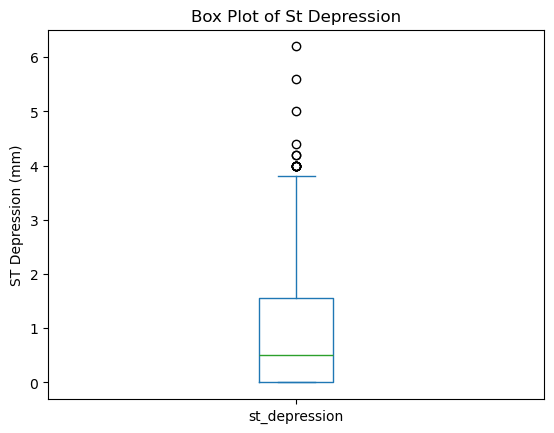

In [63]:
# Box plot to find distribution and outliers of st_depression
df['st_depression'].plot(kind = 'box', title = 'Box Plot of St Depression', ylabel = 'ST Depression (mm)')

plt.show()
# There are some outliers in st_depression, which are possible if the ST depression is steeper, due to pre-existing heart conditions for example

In [64]:
# Due to the presence of outliers, the median value will be used for st_depression imputation
st_depression_median = df['st_depression'].median()
df['st_depression'] = df['st_depression'].fillna(st_depression_median)  

In [65]:
# Verify that missing values are imputed 
df['st_depression'].isnull().sum()

0

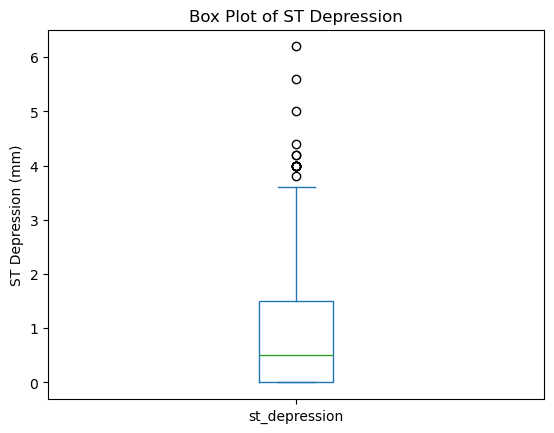

In [66]:
# Box plot to check new distribution and outliers of st_depression
df['st_depression'].plot(kind = 'box', title = 'Box Plot of ST Depression', ylabel = 'ST Depression (mm)')

plt.show()
# Relatively unchanged

## Column: slope

In [67]:
# Check correlation between slope and other categorical columns 
calculate_cramers_v(df['slope'])

# No high correlations so no multicollinearity issues
# The moderate correlation between slope and exercise_induced_angina has been observed earlier 

slope and chest_pain_type correlation: 0.24
slope and high_fasting_blood_sugar correlation: 0.13
slope and restecg correlation: 0.12
slope and exercise_induced_angina correlation: 0.4
slope and thalassemia correlation: 0.24


In [68]:
# 34% of data for slope in the remaining columns is missing. This is severe
# Because the slope of the ST segment indicates myocardial ischemia which in turn is related to heart disease, it shouldn't be removed 
df['slope'].isnull().sum() / len(df) * 100

34.51202263083451

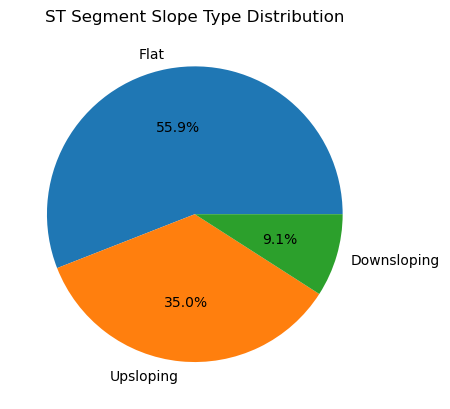

In [69]:
# Pie chart to display distribution of slope values 
slope_counts = df['slope'].value_counts()
plt.pie(slope_counts, labels = ['Flat', 'Upsloping', 'Downsloping'], autopct='%1.1f%%')
plt.title('ST Segment Slope Type Distribution')
plt.show()

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 919
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       707 non-null    int64  
 1   chest_pain_type           707 non-null    object 
 2   top_rest_bps              707 non-null    float64
 3   cholesterol               707 non-null    float64
 4   high_fasting_blood_sugar  707 non-null    object 
 5   restecg                   707 non-null    object 
 6   max_heart_rate            665 non-null    float64
 7   exercise_induced_angina   665 non-null    object 
 8   st_depression             707 non-null    float64
 9   slope                     463 non-null    object 
 10  colored_vessels           302 non-null    float64
 11  thalassemia               349 non-null    object 
 12  has_heart_disease         707 non-null    int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 77.3+ KB


In [71]:
df[df['slope'].isnull()].groupby('exercise_induced_angina').size()
# Most missing values in slope are for exercise_induced_angina = False which likely means that those without angina are not tested for slope in ST segment

exercise_induced_angina
False    175
True      28
dtype: int64

In [72]:
df[df['slope'].isnull()].groupby('chest_pain_type').size()
# Though correlation with chest_pain_type is low, most missing values occur when chest pain type is asymptomatic again suggesting that those without angina are not tested at all 

chest_pain_type
asymptomatic       87
atypical angina    85
non-anginal        60
typical angina     12
dtype: int64

In [73]:
# Since there are relations between the distribution of missing values with exercise_induced_angina and chest_pain_type, and there is a moderate correlation between slope and exercise_induced_angina,
# KNN imputation can be used for mising values in slope

## Column: colored_vessels

In [74]:
df['colored_vessels'].unique()

array([ 0.,  3.,  2.,  1., nan])

In [75]:
# 57% of data for slope in the remaining columns is missing, which is severe
# The column cannot be removed because fluoroscopy is used to diagnose heart problems including heart disease
coloured_vessels_missing = df['colored_vessels'].isnull().sum() / len(df) * 100
print(coloured_vessels_missing.round(2))

57.28


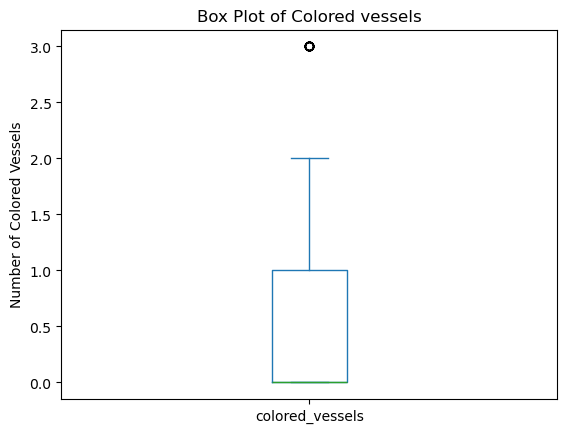

In [76]:
# Box plot to check new distribution and outliers of colored_vessels
df['colored_vessels'].plot(kind = 'box', title = 'Box Plot of Colored vessels', ylabel = 'Number of Colored Vessels')

plt.show()
# 3 is an outlier, but is still a valid value 

In [77]:
df[df['colored_vessels'].isnull()].groupby('chest_pain_type').size()
# Most of the missing values occur when chest pain is asymptomatic, suggesting that patients are not deemed to be at risk and thus do not proceed with a fluoroscopy 

chest_pain_type
asymptomatic       209
atypical angina    104
non-anginal         75
typical angina      17
dtype: int64

In [78]:
colored_vessels_missing = df[df['colored_vessels'].isnull()].groupby('st_depression').size() 
colored_vessels_missing = colored_vessels_missing[colored_vessels_missing > 0]
print(colored_vessels_missing.sort_values(ascending = False))
# Most of the missing values occur when st_depression = 0, suggesting that patients do not proceed with a fluoroscopy as they are not deemed at risk, hence the missing values 

st_depression
0.0    196
0.5     51
1.0     47
2.0     46
1.5     24
3.0     18
2.5      9
4.0      5
0.8      2
1.3      2
0.1      1
0.4      1
1.6      1
1.7      1
5.0      1
dtype: int64


In [79]:
# Given that the data may not be missing at random and that there is slight correlation between colored_vessels and age as observed in the earlier heatmap, KNN imputation can be used to handle missing values 

## Column: thalassemia

In [80]:
df['thalassemia'].unique()

array(['fixed defect', 'normal', 'reversable defect', nan], dtype=object)

In [81]:
# Correct the typo 
df['thalassemia'] = df['thalassemia'].replace('reversable defect', 'reversible defect')

In [82]:
# Check the change 
df['thalassemia'].unique()

array(['fixed defect', 'normal', 'reversible defect', nan], dtype=object)

In [83]:
# Check correlation between thalassemia and other categorical columns 
calculate_cramers_v(df['thalassemia'])

# No high correlations so no multicollinearity issues
# There is moderate correlation between thalassemia and exercise_induced_angina 

thalassemia and chest_pain_type correlation: 0.24
thalassemia and high_fasting_blood_sugar correlation: 0.16
thalassemia and restecg correlation: 0.21
thalassemia and exercise_induced_angina correlation: 0.35
thalassemia and slope correlation: 0.24


In [84]:
# 50% of data for thalassemia in the remaining columns is missing, which is severe
# The column cannot be removed because fthe presence of pre-existing illnesses like thalassemia will affect the risks of getting heart disease 
thalassemia_missing = df['thalassemia'].isnull().sum() / len(df) * 100
print(thalassemia_missing.round(2))

50.64


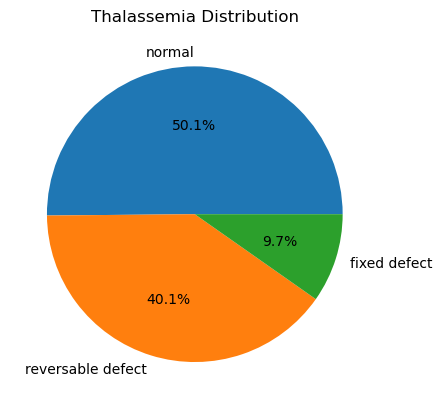

In [85]:
# Pie chart to display distribution of thalassemia values 
slope_counts = df['thalassemia'].value_counts()
plt.pie(slope_counts, labels = ['normal', 'reversable defect', 'fixed defect'], autopct = '%1.1f%%')
plt.title('Thalassemia Distribution')
plt.show()

# The distribution is imablanced in that fixed defect is a small minority, but can be considered balanced in terms of 'normal' vs 'has defect'

In [86]:
df[df['thalassemia'].isnull()].groupby('exercise_induced_angina').size() 
# Most of the missing values occur when exercise_induced_angina is false, suggesting that these patients without chest pain from exercise do not proceed with a test for Thalassemia as they are not deemed at risk, hence the missing values 
# since there is a moderate correlation with exercise_induced_angina and the data may not be missing at random, thalassemia missing values can be imputed with KNN

exercise_induced_angina
False    187
True     129
dtype: int64

In [87]:
# Check for columns with remaining missing values 
df.isnull().sum() 

age                           0
chest_pain_type               0
top_rest_bps                  0
cholesterol                   0
high_fasting_blood_sugar      0
restecg                       0
max_heart_rate               42
exercise_induced_angina      42
st_depression                 0
slope                       244
colored_vessels             405
thalassemia                 358
has_heart_disease             0
dtype: int64

In [88]:
# Define list of categorical columns' names
categorical_columns = ['chest_pain_type', 'high_fasting_blood_sugar', 'restecg', 'exercise_induced_angina', 'slope', 'thalassemia']

# Find indexes of rows with missing values in categorical columns 
# These rows will be accessed to verify that the missing values were imputed 
for column in categorical_columns:
    missing_indexes = df[df[column].isnull()].index
    if len(missing_indexes) > 0:
        print(f'Indexes of rows with missing in {column}:\n{missing_indexes}\n')

Indexes of rows with missing in exercise_induced_angina:
Index([393, 749, 756, 758, 764, 777, 780, 789, 792, 797, 807, 809, 814, 816,
       829, 830, 831, 832, 833, 834, 835, 844, 849, 853, 856, 857, 861, 862,
       864, 865, 867, 869, 878, 879, 881, 883, 887, 888, 894, 905, 916, 918],
      dtype='int64')

Indexes of rows with missing in slope:
Index([303, 304, 306, 307, 308, 309, 310, 311, 312, 313,
       ...
       906, 907, 909, 913, 914, 915, 916, 917, 918, 919],
      dtype='int64', length=244)

Indexes of rows with missing in thalassemia:
Index([ 87, 266, 303, 304, 307, 308, 309, 310, 311, 312,
       ...
       907, 908, 910, 911, 912, 913, 915, 916, 918, 919],
      dtype='int64', length=358)



In [89]:
# Use one-hot encoding to encode categorical columns in the DataFrame 
encoded_df = pd.get_dummies(df, columns = categorical_columns, drop_first = False)

In [90]:
# Apply KNNImputer using 3 neighbours 
imputer = KNNImputer(n_neighbors = 3)
imputed_data = imputer.fit_transform(encoded_df)
# Store the DataFrame with imputed values as imputed_df using the same columns as in the encoded DataFrame and same indexes as in the original DataFrame
imputed_df = pd.DataFrame(imputed_data, columns = encoded_df.columns, index = df.index)

In [91]:
# Reverse one-hot encoding to retrieve imputed values
# This is because imputed values are the mean, which could be below 1 as values of one-hot encoded columns are 0-1, making them appear as 0 

# Iterate through categorical_columns
for original_column in categorical_columns:
    # Get the encoded columns for the current categorical column 
    encoded_columns = [column for column in encoded_df.columns if column.startswith(original_column + '_')]
    # Get the categorical value by identifying which encoded column has the highest numeric value 
    # If the row had no missing values, it will get the encoded column which had the value of 1 
    # If the row had missing values, it will get the encoded column with the highest mean that suggested this encoded column is most likely the value 
    value = imputed_df[encoded_columns].idxmax(axis = 1)
    # Get the original categorical value from the encoded column name and assign it to the original column
    # Use the encoded column name to recreate the categorical value 
    imputed_df[original_column] = value.str.replace(original_column + '_', '')
    # Drop the encoded columns 
    imputed_df = imputed_df.drop(columns = encoded_columns)

In [92]:
# Compare the original and imputed DataFrames
print('Original DataFrame:')
df.info()
print()
print('Imputed DataFrame:')
imputed_df.info()

Original DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 919
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       707 non-null    int64  
 1   chest_pain_type           707 non-null    object 
 2   top_rest_bps              707 non-null    float64
 3   cholesterol               707 non-null    float64
 4   high_fasting_blood_sugar  707 non-null    object 
 5   restecg                   707 non-null    object 
 6   max_heart_rate            665 non-null    float64
 7   exercise_induced_angina   665 non-null    object 
 8   st_depression             707 non-null    float64
 9   slope                     463 non-null    object 
 10  colored_vessels           302 non-null    float64
 11  thalassemia               349 non-null    object 
 12  has_heart_disease         707 non-null    int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 7

In [93]:
# Re-order the imputed DataFrame's columns to match the original
original_order = list(df.columns.values)
imputed_df = imputed_df[original_order]
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 919
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       707 non-null    float64
 1   chest_pain_type           707 non-null    object 
 2   top_rest_bps              707 non-null    float64
 3   cholesterol               707 non-null    float64
 4   high_fasting_blood_sugar  707 non-null    object 
 5   restecg                   707 non-null    object 
 6   max_heart_rate            707 non-null    float64
 7   exercise_induced_angina   707 non-null    object 
 8   st_depression             707 non-null    float64
 9   slope                     707 non-null    object 
 10  colored_vessels           707 non-null    float64
 11  thalassemia               707 non-null    object 
 12  has_heart_disease         707 non-null    float64
dtypes: float64(7), object(6)
memory usage: 77.3+ KB


In [94]:
# Replace float values in colored_vessels with their ceiling as the number of colored vessels should be whole 
# Ceiling is used so that values with .5 or higher are rounded up since it is more likely that the vessel was colored 
imputed_df['colored_vessels'] = np.ceil(imputed_df['colored_vessels'])
# Convert some of the imputed columns meant to represent integer values to integer as imputation made them of float data type, or they make more sense as integer 
columns_to_convert = ['age', 'colored_vessels', 'has_heart_disease']
for column in columns_to_convert:
    imputed_df[column] = imputed_df[column].astype('int64')

In [95]:
# Verify changes
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 0 to 919
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       707 non-null    int64  
 1   chest_pain_type           707 non-null    object 
 2   top_rest_bps              707 non-null    float64
 3   cholesterol               707 non-null    float64
 4   high_fasting_blood_sugar  707 non-null    object 
 5   restecg                   707 non-null    object 
 6   max_heart_rate            707 non-null    float64
 7   exercise_induced_angina   707 non-null    object 
 8   st_depression             707 non-null    float64
 9   slope                     707 non-null    object 
 10  colored_vessels           707 non-null    int64  
 11  thalassemia               707 non-null    object 
 12  has_heart_disease         707 non-null    int64  
dtypes: float64(4), int64(3), object(6)
memory usage: 77.3+ KB


In [96]:
# Check if there are missing values remaining
imputed_df.isnull().sum()

age                         0
chest_pain_type             0
top_rest_bps                0
cholesterol                 0
high_fasting_blood_sugar    0
restecg                     0
max_heart_rate              0
exercise_induced_angina     0
st_depression               0
slope                       0
colored_vessels             0
thalassemia                 0
has_heart_disease           0
dtype: int64

In [97]:
# Verify if the categorical missing data in exercise_induced_angina, slope and thalassemia has been imputed 
print(f'Row before:\n{df.loc[830]}')
print()
print(f'Row after:\n{imputed_df.loc[830]}')

Row before:
age                                     65
chest_pain_type               asymptomatic
top_rest_bps                         130.0
cholesterol                          312.0
high_fasting_blood_sugar             False
restecg                     lv hypertrophy
max_heart_rate                         NaN
exercise_induced_angina                NaN
st_depression                          0.5
slope                                  NaN
colored_vessels                        NaN
thalassemia                            NaN
has_heart_disease                        1
Name: 830, dtype: object

Row after:
age                                     65
chest_pain_type               asymptomatic
top_rest_bps                         130.0
cholesterol                          312.0
high_fasting_blood_sugar             False
restecg                     lv hypertrophy
max_heart_rate                  129.666667
exercise_induced_angina              False
st_depression                          0.5
slope

In [98]:
# Verify if categorical values in rows with non-missing values have been altered somehow 
print(f'Row before:\n{df.loc[50]}')
print()
print(f'Row after:\n{imputed_df.loc[50]}')

Row before:
age                                      41
chest_pain_type             atypical angina
top_rest_bps                          105.0
cholesterol                           198.0
high_fasting_blood_sugar              False
restecg                              normal
max_heart_rate                        168.0
exercise_induced_angina               False
st_depression                           0.0
slope                             upsloping
colored_vessels                         1.0
thalassemia                          normal
has_heart_disease                         0
Name: 50, dtype: object

Row after:
age                                      41
chest_pain_type             atypical angina
top_rest_bps                          105.0
cholesterol                           198.0
high_fasting_blood_sugar              False
restecg                              normal
max_heart_rate                        168.0
exercise_induced_angina               False
st_depression               

## Splitting

In [99]:
# Define seed to maintain reproducibility in results 
seed = 7

In [100]:
# Store target column in y
y = imputed_df['has_heart_disease']

# Remove target column from DataFrame
del imputed_df['has_heart_disease']

# Store remaining columns in X
X = imputed_df

In [101]:
# Selecting 2 random rows from the dataset for testing later
test_data = imputed_df.sample(n = 2, random_state = 12)

# Store the target values for the selected test rows
test_data_targets = y.loc[test_data.index]

In [102]:
# Remove the selected rows from the dataset
imputed_df = imputed_df.drop(index = test_data.index)

# Remove the selected rows' targets from y 
y = y.drop(test_data.index)

y = y

# Update X after removing the test rows
X = imputed_df

# Split the data into training and testing (80%, 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = seed)

# Store the test data features for later use
test_data_features = test_data

test_data_targets = test_data_targets

In [103]:
# Look at the features of the rows to test the deployed model
test_data_features

,age,chest_pain_type,top_rest_bps,cholesterol,high_fasting_blood_sugar,restecg,max_heart_rate,exercise_induced_angina,st_depression,slope,colored_vessels,thalassemia
486,60,non-anginal,120.0,246.0,False,lv hypertrophy,135.0,False,0.0,downsloping,1,fixed defect
161,77,asymptomatic,125.0,304.0,False,lv hypertrophy,162.0,True,0.0,upsloping,3,normal


In [104]:
test_data_targets

486    0
161    1
Name: has_heart_disease, dtype: int64

# Model Building

In [105]:
def display_results(results):
    for model_name, result in results.items():
        # Display the results of each model 
        print(f'Model: {model_name}')
        if result['best_params'] != None:
            print(f'Best Parameters: {result["best_params"]}')
        print(f'Training Accuracy: {result["train_accuracy"]:.2f}')
        print(f'Testing Accuracy: {result["test_accuracy"]:.2f}')
        print('Testing Classification Report:')
        print(result['test_report'])
        
        # Display confusion matrix  
        print('Testing Confusion Matrix:')
        test_conf_matrix_disp = ConfusionMatrixDisplay(confusion_matrix = result['test_confusion_matrix'])
        test_conf_matrix_disp.plot(cmap='Blues', values_format='d')
        plt.title(f'{model_name} - Testing Confusion Matrix')
        plt.show()
        
        print('-' * 40)

In [106]:
# Define the preprocessor to one-hot encode categorical X values 
preprocessor = ColumnTransformer(
    transformers=[
        # Use the categorical_columns list defined earlier to specify which columns to encode 
        ('encoding', OneHotEncoder(drop = 'first'), categorical_columns)
    ],
    # Keep the other columns 
    remainder='passthrough'
)

# Define pipelines for each model to encode and normalize train and test data (separately), then instantiate model
# Robust Scaling is used as there are outliers in the data
pipelines = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('classifier', LogisticRegression(random_state = seed))
    ]),
    'Naive Bayes': Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('classifier', GaussianNB())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('classifier', RandomForestClassifier(random_state = seed))
    ]),
    'HistGradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('classifier', HistGradientBoostingClassifier(random_state = seed))
    ]),
    'Support Vector Machine': Pipeline([
        ('preprocessor', preprocessor),
        ('scaler', RobustScaler()),
        ('classifier', SVC(random_state = seed))
    ])
}

In [107]:
results_without_tuning = {}

In [108]:
# Iterate through the pipelines for each model specified in pipelines dictionary
for model_name, pipeline in pipelines.items():    
    # Fit the grid search to the training data
    pipeline.fit(X_train, y_train)

    # Use the best model to make predictions on training data
    y_train_pred = pipeline.predict(X_train)
    # Use the best model to make predictions on test data
    y_test_pred = pipeline.predict(X_test)
    
    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute confusion matrices
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Store the best model, best parameters and results in results dictionary under key model_name
    results_without_tuning[model_name] = {
        'best_params': None,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_report': classification_report(y_test, y_test_pred),    
        'test_confusion_matrix' : test_confusion_matrix,
    }

Model: Logistic Regression
Training Accuracy: 0.81
Testing Accuracy: 0.82
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        71
           1       0.85      0.79      0.81        70

    accuracy                           0.82       141
   macro avg       0.82      0.82      0.82       141
weighted avg       0.82      0.82      0.82       141

Testing Confusion Matrix:


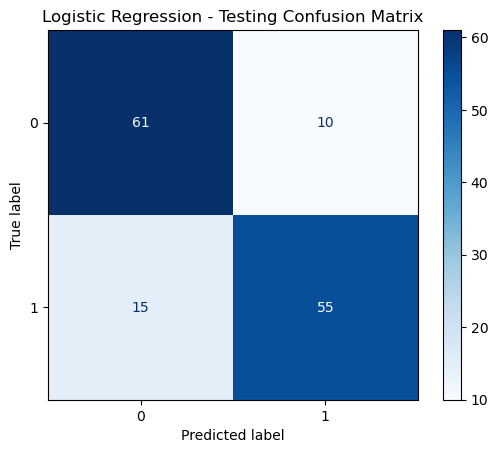

----------------------------------------
Model: Naive Bayes
Training Accuracy: 0.82
Testing Accuracy: 0.84
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        71
           1       0.86      0.80      0.83        70

    accuracy                           0.84       141
   macro avg       0.84      0.84      0.84       141
weighted avg       0.84      0.84      0.84       141

Testing Confusion Matrix:


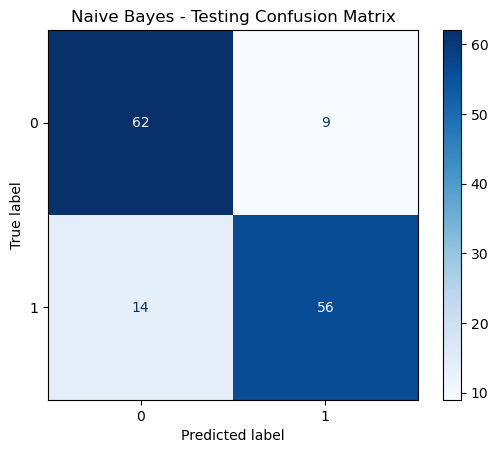

----------------------------------------
Model: Random Forest
Training Accuracy: 1.00
Testing Accuracy: 0.80
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        71
           1       0.82      0.77      0.79        70

    accuracy                           0.80       141
   macro avg       0.80      0.80      0.80       141
weighted avg       0.80      0.80      0.80       141

Testing Confusion Matrix:


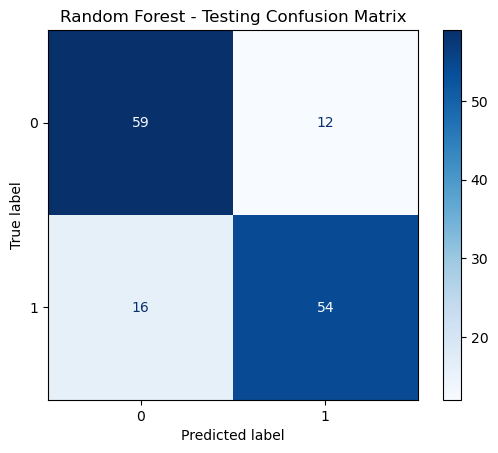

----------------------------------------
Model: HistGradientBoosting
Training Accuracy: 1.00
Testing Accuracy: 0.78
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.80      0.79        71
           1       0.79      0.76      0.77        70

    accuracy                           0.78       141
   macro avg       0.78      0.78      0.78       141
weighted avg       0.78      0.78      0.78       141

Testing Confusion Matrix:


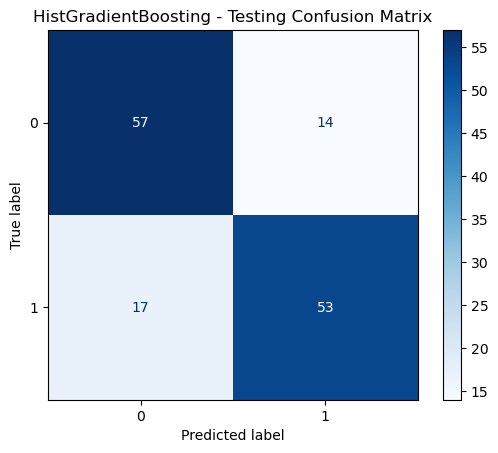

----------------------------------------
Model: Support Vector Machine
Training Accuracy: 0.89
Testing Accuracy: 0.83
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        71
           1       0.84      0.81      0.83        70

    accuracy                           0.83       141
   macro avg       0.83      0.83      0.83       141
weighted avg       0.83      0.83      0.83       141

Testing Confusion Matrix:


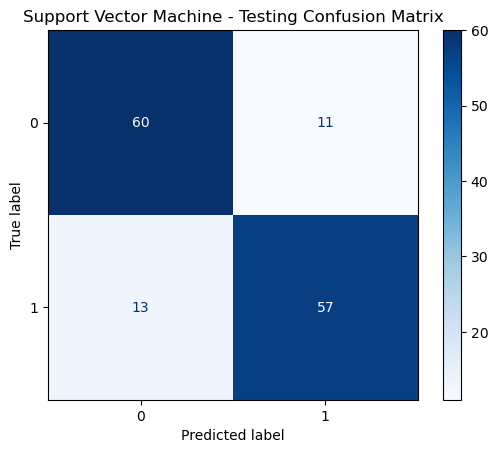

----------------------------------------


In [109]:
# Look at the targets
display_results(results_without_tuning)

# Hyper-Parameter Tuning 

The following code uses GridSearch to find the optimal combination of parameters from the ones defined in param_grids below.

The code executing the full grid search is commented to save time. Instead, there is a recreation of the models with the best combinations and their metrics found below.

In [110]:
# Define parameter grids for hyperparameter tuning
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.01, 0.1, 0.5, 1],
        'classifier__solver': ['lbfgs', 'liblinear', 'newton-cholesky'],
        'classifier__max_iter': [100, 200, 300, 400, 500]
    },
    # Naive Bayes does not have hyperparameters to set
    'Naive Bayes': {},  
    'Random Forest': {
        'classifier__n_estimators': [50, 100, 150, 200],
        'classifier__max_depth': [None, 4, 10, 20, 40],
        'classifier__min_samples_split': [2, 5, 8, 11, 15],
        'classifier__min_samples_leaf': [1, 3, 5, 8, 10],
        'classifier__max_features' : ['sqrt', 'log2', 0.2, 0.3],
        'classifier__max_leaf_nodes' : [None, 20, 50, 100, 200]
    },
    'HistGradientBoosting': {
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_iter': [50, 100, 150, 200, 300],
        'classifier__max_leaf_nodes': [None, 31, 50, 100],
        'classifier__max_depth': [None, 5, 10, 30, 50],
        'classifier__min_samples_leaf': [5, 10, 15, 20],
        'classifier__max_features': [0.1, 0.3, 0.6, 1.0],
        'classifier__max_bins': [150, 200, 255]
    },
    'Support Vector Machine': {
        'classifier__C': [0.1, 0.5, 1, 1.3],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__gamma': ['scale', 'auto']
    }
}


In [111]:
# Define cross_validation method and attributes to use as well as seed for reproducibility 
# StratifiedKFolds used to preserve original distribution when sampling
cross_validation = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

In [112]:
# # Define a dictionary to store training and testing results
# results_with_tuning = {}

In [113]:
# # Iterate through the pipelines for each model specified in pipelines dictionary
# for model_name, pipeline in pipelines.items():    
#     # Get the parameter grid for the model using the model name 
#     param_grid = param_grids.get(model_name)

#     # Initialise GridSearchCV for each model 
#     # Use the retrieved param_grid
#     # Use all processors to speed up the process
#     # Use accuracy scoring to determine best model 
#     # Use earlier defined cross_validation
#     search = GridSearchCV(pipeline, param_grid, n_jobs = -1, scoring = 'accuracy', cv = cross_validation)
    
#     # Fit the grid search to the training data
#     search.fit(X_train, y_train)
    
#     # Get the best model from the search
#     best_model = search.best_estimator_
#     # Get the hyperparameters of the best model  
#     best_params = search.best_params_

#     # Use the best model to make predictions on training data
#     y_train_pred = best_model.predict(X_train)
#     # Use the best model to make predictions on test data
#     y_test_pred = best_model.predict(X_test)
    
#     # Evaluate the model
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Compute confusion matrices
#     test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    
#     # Store the best model, best parameters and results in results dictionary under key model_name
#     results_with_tuning[model_name] = {
#         'best_model': best_model,
#         'best_params': best_params,
#         'train_accuracy': train_accuracy,
#         'test_accuracy': test_accuracy,
#         'test_report': classification_report(y_test, y_test_pred),    
#         'test_confusion_matrix': test_confusion_matrix,
#     }

In [114]:
# display_results(results_with_tuning)

## Recreation of Models with Best Combinations GridSearch Found

In [115]:
# Define parameter grids but only with optimised parameters found from earlier grid search
optimal_param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.5],
        'classifier__solver': ['lbfgs'],
        'classifier__max_iter': [100]
    },
    # Naive Bayes does not have hyperparameters to set
    'Naive Bayes': {},  
    'Random Forest': {
        'classifier__n_estimators': [50],
        'classifier__max_depth': [None],
        'classifier__min_samples_split': [11],
        'classifier__min_samples_leaf': [1],
        'classifier__max_features' : ['sqrt'],
        'classifier__max_leaf_nodes' : [None]
    },
    'HistGradientBoosting': {
        'classifier__learning_rate': [0.01],
        'classifier__max_iter': [50],
        'classifier__max_leaf_nodes': [50],
        'classifier__max_depth': [10],
        'classifier__min_samples_leaf': [5],
        'classifier__max_features': [0.1],
        'classifier__max_bins': [150]
    },
    'Support Vector Machine': {
        'classifier__C': [1],
        'classifier__kernel': ['rbf'],
        'classifier__gamma': ['auto']
    }
}


In [116]:
results_with_tuning = {}

In [117]:
# Iterate through the pipelines for each model specified in pipelines dictionary
for model_name, pipeline in pipelines.items():    
    # Get the parameter grid for the model using the model name 
    param_grid = optimal_param_grids.get(model_name)

    # Initialise GridSearchCV for each model 
    # Use the retrieved param_grid
    # Use all processors to speed up the process
    # Use accuracy scoring to determine best model 
    # Use earlier defined cross_validation
    search = GridSearchCV(pipeline, param_grid, n_jobs = -1, scoring = 'accuracy', cv = cross_validation)
    
    # Fit the grid search to the training data
    search.fit(X_train, y_train)
    
    # Get the best model from the search
    best_model = search.best_estimator_
    # Get the hyperparameters of the best model  
    best_params = search.best_params_

    # Use the best model to make predictions on training data
    y_train_pred = best_model.predict(X_train)
    # Use the best model to make predictions on test data
    y_test_pred = best_model.predict(X_test)
    
    # Evaluate the model
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Compute confusion matrices
    test_confusion_matrix = confusion_matrix(y_test, y_test_pred)
    
    # Store the best model, best parameters and results in results dictionary under key model_name
    results_with_tuning[model_name] = {
        'best_model': best_model,
        'best_params': best_params,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_report': classification_report(y_test, y_test_pred),    
        'test_confusion_matrix': test_confusion_matrix,
    }

Model: Logistic Regression
Best Parameters: {'classifier__C': 0.5, 'classifier__max_iter': 100, 'classifier__solver': 'lbfgs'}
Training Accuracy: 0.82
Testing Accuracy: 0.82
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        71
           1       0.84      0.80      0.82        70

    accuracy                           0.82       141
   macro avg       0.82      0.82      0.82       141
weighted avg       0.82      0.82      0.82       141

Testing Confusion Matrix:


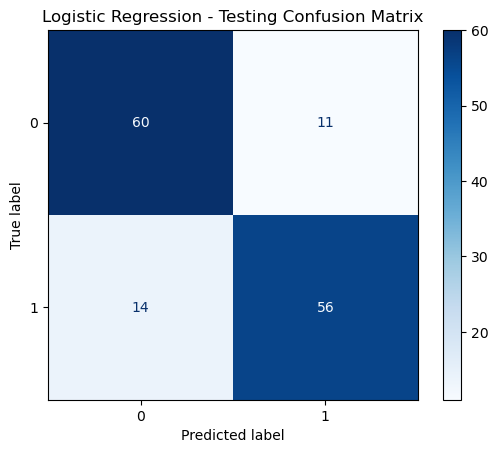

----------------------------------------
Model: Naive Bayes
Best Parameters: {}
Training Accuracy: 0.82
Testing Accuracy: 0.84
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        71
           1       0.86      0.80      0.83        70

    accuracy                           0.84       141
   macro avg       0.84      0.84      0.84       141
weighted avg       0.84      0.84      0.84       141

Testing Confusion Matrix:


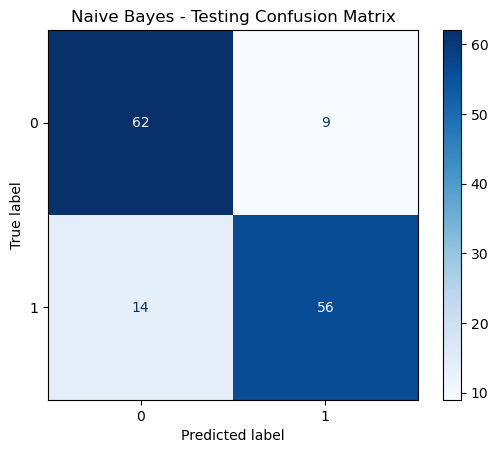

----------------------------------------
Model: Random Forest
Best Parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__max_leaf_nodes': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 11, 'classifier__n_estimators': 50}
Training Accuracy: 0.92
Testing Accuracy: 0.81
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81        71
           1       0.80      0.81      0.81        70

    accuracy                           0.81       141
   macro avg       0.81      0.81      0.81       141
weighted avg       0.81      0.81      0.81       141

Testing Confusion Matrix:


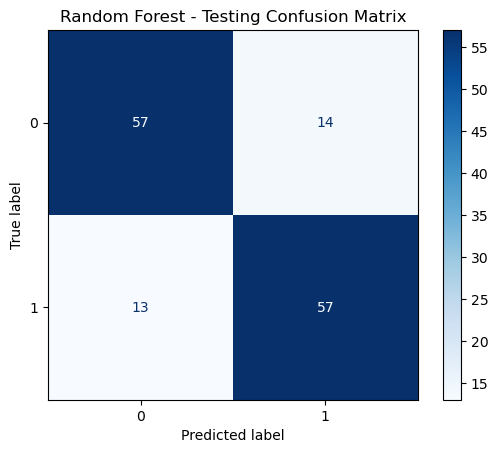

----------------------------------------
Model: HistGradientBoosting
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_bins': 150, 'classifier__max_depth': 10, 'classifier__max_features': 0.1, 'classifier__max_iter': 50, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 5}
Training Accuracy: 0.89
Testing Accuracy: 0.82
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        71
           1       0.83      0.79      0.81        70

    accuracy                           0.82       141
   macro avg       0.82      0.82      0.82       141
weighted avg       0.82      0.82      0.82       141

Testing Confusion Matrix:


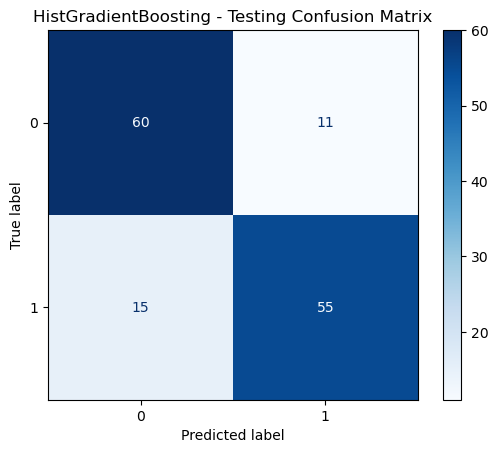

----------------------------------------
Model: Support Vector Machine
Best Parameters: {'classifier__C': 1, 'classifier__gamma': 'auto', 'classifier__kernel': 'rbf'}
Training Accuracy: 0.86
Testing Accuracy: 0.83
Testing Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83        71
           1       0.84      0.81      0.83        70

    accuracy                           0.83       141
   macro avg       0.83      0.83      0.83       141
weighted avg       0.83      0.83      0.83       141

Testing Confusion Matrix:


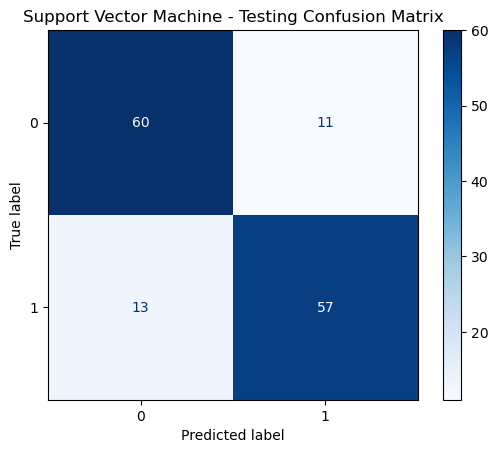

----------------------------------------


In [118]:
display_results(results_with_tuning)

# Model Export

In [119]:
# The Support Vector Classifier will be used for deployment as it was the best performing one
# Store the pipeline with the model into variable svm 
svm = results_with_tuning['Support Vector Machine']['best_model']

In [120]:
# Save svm to a file for use in streamlit application
joblib.dump(svm, 'trained_heart_disease_classifier_model.pkl')

['trained_heart_disease_classifier_model.pkl']

# Streamlit Chatbot Reflection

Through my experience with the chatbot, I learnt about Streamlit's uses and capabilities. 

I learnt that Streamlit helps individuals specialising in data science and machine learning such as data scientists to deploy their models onto a simple and interactive web interface, allowing external users to be able to input their own data to generate predictions from the model. It caters especially to those who want to produce and publish prototypes of their models quickly, given its simple syntax that allows even those with little web-development experience to make a website for their model's deployment. However, such simplicity also leads to stiffness in customisation as there are few options to change text styles and website colours unless one uses markdowns and html code. 

The chatbot has also walked me through a step-by-step examples to illustrate and teach me the end-to-end process of using streamlit to deploy my machine learning model, from importing the model and necessary libraries (pandas, etc) to running the app locally or deploying it to cloud. When teaching how to design the website interface, it explores the various Streamlit function to show me how diverse inputs can be captured uniquely and interactively. For example, using sliders and select boxes for continuous and discrete data respectively. These widgets can have settings including ranges and options too to keep raw inputs more realistic. It also taught me to use other widgets such as st.header to separate and organise sections of the website, and st.write to display the output of predictions.  